# Prepare robots first  
* run panda repeater on controller pc  

```
ssh panda@192.168.0.172
roslaunch panda_ros_repeater joint_velocity_repeater.launch robot_ip:=192.168.0.13 load_gripper:=false

```

* Keep indy connected to conty to bypass conty-connection delay bug

# initialize notebook

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Initialize constants

In [2]:
from pkg.marker_config import *
from pkg.constraint_graph import *
from pkg.constraint.constraint_action import *
from pkg.constraint.constraint_object import *
from pkg.constants import *
from pkg.utils.plot_utils import *
from pkg.utils.utils import *
from pkg.environment_builder import *
from pkg.ui.ui_broker import *
from pkg.controller.combined_robot import *

gtimer = GlobalTimer.instance()
gtimer.reset()

In [3]:
crob = CombinedRobot(connection_list=(False, False))

connection_list
(False, False)


# initialize graph & ui

In [4]:
if "cam" not in locals():
    cam = None # StereoCamera.instance()

# set urdf
xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, XYZ_RPY_ROBOTS_DEFAULT, crob.custom_limits, start_rviz=True)
ghnd = GeometryHandle(urdf_content)


graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                        urdf_content=urdf_content, combined_robot=crob)
graph.set_camera(cam)
graph.set_cam_robot_collision(_add_cam_poles=False)
graph.set_rviz()

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(graph)
ui_broker.start_server()

# set rviz
graph.set_rviz(crob.home_pose)
ui_broker.set_tables()

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [5]:
from pkg.planner.moveit import moveit_py
from pkg.planner.moveit.moveit_planner import MoveitPlanner

In [6]:
mplan = MoveitPlanner(
    joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content, 
    robot_names=crob.robot_names, ghnd=ghnd)

In [43]:
group_name, tool_link, base_link,  = "indy0", "indy0_tcp", "base_link"
tool_offset = (0,0,0,0,0,0,1)
fix_surface, fix_normal = True, True
radius, tol = 1e-3, 1e-3

In [44]:
init_joints = crob.home_pose
tool_tf = get_tf(tool_link, list2dict(init_joints, crob.joint_names), graph.urdf_content, from_link=base_link)
tool_xyzrpy = T2xyzrpy(tool_tf)
tool_xyzquat = T2xyzquat(tool_tf)

In [45]:
const_plane = ghnd.create_safe(gtype=GEOTYPE.BOX, name="plane", link_name="base_link",
                               center=tool_xyzrpy[0], rpy=tool_xyzrpy[1], 
                               dims=(3,3,0.001), color=(1, 1, 0, 0.5),
                               collision=False)
graph.add_marker(const_plane)

In [46]:
plane_pose = tuple(const_plane.center) + tuple(Rotation.from_dcm(const_plane.orientation_mat).as_quat())

In [47]:
geometry_list = moveit_py.make_assign_arr(moveit_py.mpc.GeometryList,
                                          [moveit_py.mpc.Geometry(moveit_py.mpc.Shape.PLANE,  moveit_py.CartPose(*plane_pose), moveit_py.Vec3(0,0,0))]
                                         )

In [48]:
mplan.planner.clear_manifolds()
if fix_surface:
    mplan.planner.add_union_manifold(group_name, tool_link, moveit_py.CartPose(*tool_offset),
                                        geometry_list, True, False, radius, tol)
if fix_normal:
    mplan.planner.add_union_manifold(group_name, tool_link, moveit_py.CartPose(*tool_offset),
                                        geometry_list, False, True, radius, tol)

In [49]:
goal_pose = list.__add__(*T2xyzquat(np.matmul(tool_tf, SE3(np.identity(3), (-0.1,0.1,0)))))
timeout = 5

In [50]:
mplan.planner.clear_context_cache()
plan_res=mplan.planner.plan_with_constraints(group_name, tool_link, moveit_py.CartPose(*goal_pose), base_link, moveit_py.JointState(crob.joint_num, *init_joints), 
                                             "RRTConnectkConfigDefault",
                                             timeout, False)
print('result: {} ({})'.format(plan_res.success, len(plan_res.trajectory)))

result: False (0)


In [51]:
trajectory = np.array([moveit_py.spread(Q, crob.joint_num) for Q in moveit_py.spread(plan_res.trajectory, len(plan_res.trajectory))])

In [52]:
graph.show_motion(trajectory)

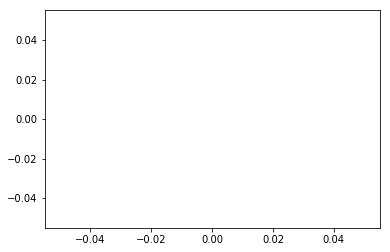

In [53]:
plt.plot(trajectory)

In [54]:
graph.remove_geometry(const_plane)